## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from frank.geometry import SourceGeometry
from frank.io import load_uvtable
from frank.radial_fitters import FrankFitter, FourierBesselFitter
import frank

import os

## Constants

In [2]:
rad_to_arcsec = 3600 * 180 / np.pi

## Functions

In [3]:
def plot_Vis(image, name):
    fftImagAsym = np.fft.fft2(image)
    fftImagAsymshifted = np.fft.fftshift(np.fft.fft2(image))
    fig, axes = plt.subplots(figsize=(10,4))
    plt.clf()
    plt.suptitle('The FFT of ' + name)
    plt.subplot(1,2,1)
    plt.title("amplitude")
    plt.imshow(np.abs(fftImagAsymshifted), cmap='hot') #amplitude (decibels)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title("phase")
    plt.imshow(np.angle(fftImagAsymshifted), cmap='hot') #phase
    plt.colorbar()
    return fftImagAsym

In [4]:
def deproject(u, v, Re, Im, inc, pa, dRa, dDec, inverse=False):
    '''
    Deprojects or projects visibilities
    '''
    # Convert to radian
    pa  = pa  * np.pi / 180.
    inc = inc * np.pi / 180.
    dDec *= np.pi / (180. * 3600)
    dRa  *= np.pi / (180. * 3600)
    # Correct the phase position by dRA and dDec
    if not inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (u * -dRa + v * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Calculate transformation
    cos_t = np.cos(pa)
    sin_t = np.sin(pa)
    aux = 1.
    if inverse:
        sin_t *= -1.
        aux = 1. / np.cos(inc)
    up = u * aux * cos_t - v * sin_t
    vp = u * aux * sin_t + v * cos_t
    #   Deproject
    if not inverse:
        up *= np.cos(inc)
    if inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (up * -dRa + vp * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Return
    return up, vp, Rep, Imp


# Real plane

In [5]:
# Dimensiones de la imagen
dim = 900
image_width = Nx = 900
image_height = Ny = 900

# Crear una matriz de píxeles de ejemplo
image = np.ones((image_height, image_width))

## Delta ring

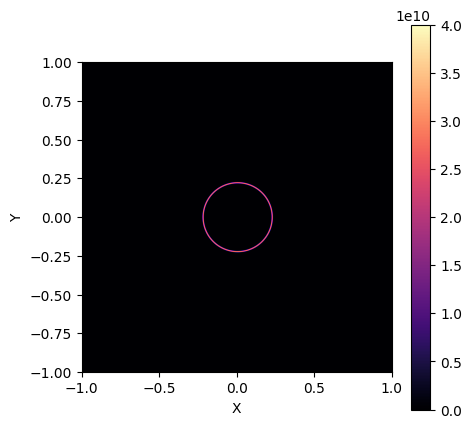

In [6]:
def ring_parameters(center_x, center_y, radius, image_width, image_height):
    # Coordenadas donde deseas agregar el anillo
    x = np.arange(image_width) - center_x
    y = np.arange(image_height) - center_y
    return x, y, radius

def delta_ring(x, y, radius, epsilon):
    # Calcular la distancia radial desde el centro
    R = np.sqrt(x[:, np.newaxis]**2 + y[np.newaxis, :]**2)
    # Aproximar la función delta como una Gaussiana estrecha alrededor de radius
    delta_approx = np.exp(-((R - radius)**2) / (2 * epsilon**2)) / (epsilon * np.sqrt(2 * np.pi))
    return delta_approx

# Definir parámetros del anillo
center_x, center_y = image_width // 2, image_height // 2
radius = 100  # Radio del anillo
epsilon = 1  # Valor pequeño para la aproximación de la delta

# Obtener las coordenadas y el radio del anillo
x, y, radius = ring_parameters(center_x, center_y, radius, image_width, image_height)

# Calcular el valor del anillo en cada punto de la imagen
ring = delta_ring(x, y, radius, epsilon)

# Normalizar la función delta aproximada para que los valores estén en el rango [0, 1]
ring /= np.max(ring)

ring *= 0.4e11 

plt.figure(figsize=(5, 5))
plt.imshow(ring, extent=(-1, 1, -1, 1), cmap='magma')
plt.colorbar()
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Visibility plane

In [22]:
dir = "../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)

In [23]:
# AS209 - Huang et al. 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
r_out = 1.9 #arcsecs

In [24]:
# Deprojection
du, dv, dRe, dIm = deproject(u=u, v=v, Re=Re, Im=Imag,
                             inc=inc, pa=pa, dRa=dra, dDec=ddec,
                             inverse=False)
baseline = np.sqrt(du**2 + dv**2)

## Delta ring

In [12]:
file_name = 'delta_ring'

In [13]:
from scipy.special import j0

ReV = np.median(Re[np.where(baseline<3e4)])*np.real(j0(2.*np.pi*(r_out/rad_to_arcsec/2.)*baseline))

In [14]:
ReV

array([-0.02989617, -0.07808702,  0.07037571, ..., -0.02432114,
       -0.016631  ,  0.01623501])

In [15]:
np.median(Re[np.where(baseline<3e4)])

np.float64(0.2510019)

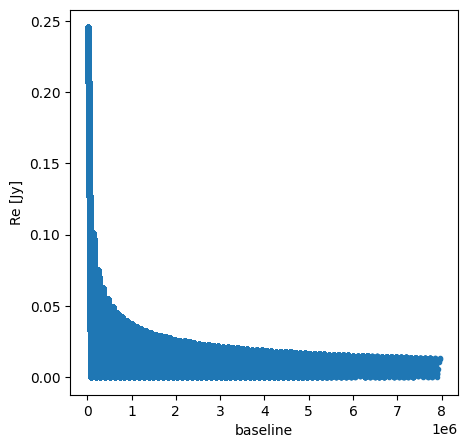

In [64]:
plt.figure(figsize=(5, 5))
plt.plot(baseline, np.abs(ReV), '.')
plt.xlabel("baseline")
plt.ylabel("Re [Jy]")
plt.show()

In [17]:
def Vis_delta_ring(u, v, Re, r_out):
    baseline = np.sqrt(u**2 + v**2)
    A0 = np.median(Re[np.where(baseline<3e4)[0]])
    return A0 * np.real(j0(2.*np.pi*(r_out/rad_to_arcsec/2.)*baseline))

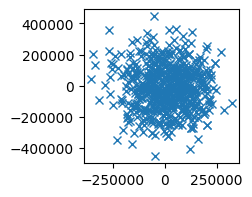

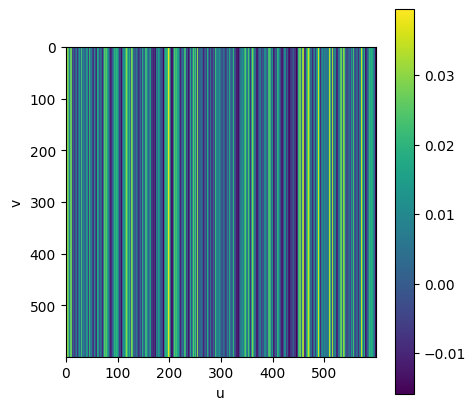

In [79]:
# Crear una malla de coordenadas (u, v)
n = 600
u_, v_ = np.meshgrid(du[:n], dv[:n])
u_, v_ = u_.reshape(-1), u_.reshape(-1)

plt.figure(figsize=(2, 2))
plt.plot(du[:n], dv[:n], 'x')
plt.xlabel("u")
plt.ylabel("v")
plt.show()

image = Vis_delta_ring(u_, v_, dRe, r_out)

ft_image = image.reshape(n, n)
plt.figure(figsize=(5, 5))
plt.imshow(ft_image, cmap='viridis')
plt.colorbar()
plt.xlabel("u")
plt.ylabel("v")
plt.show()

In [25]:
u = du
v = dv
Re = ReV
Imag = np.zeros(len(ReV))

## FFT

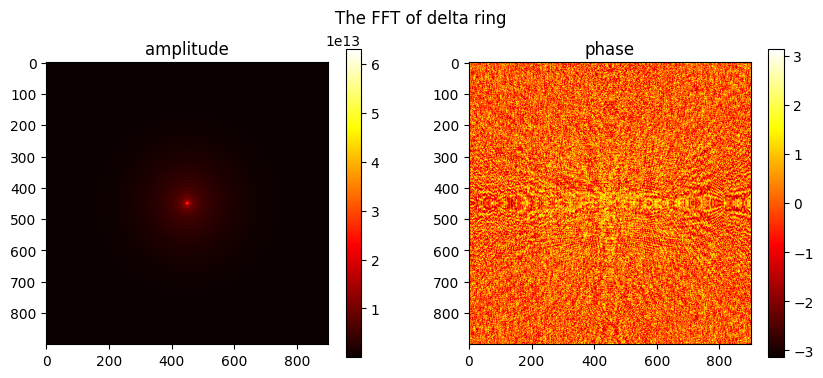

In [54]:
fftDelta = plot_Vis(ring, 'delta ring')

<Figure size 1500x1500 with 0 Axes>

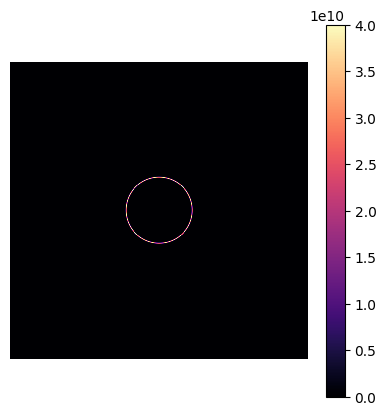

In [55]:
ifftImagAsym = np.fft.ifft2(fftDelta)
plt.figure(figsize=(15, 15))
plt.matshow(np.abs(ifftImagAsym), cmap='magma')
plt.colorbar()
plt.axis('off')
plt.show()

# Save data 

In [26]:
dir_ = "../data/"
np.save(dir_ + file_name, [u, v, Re, Imag, Weights])

# Run Frank

In [47]:
# load data
u, v, Re, Imag, Weights = np.load(dir_ + file_name + '.npy')

In [48]:
Vis = Re + Imag*1j

In [210]:
N = 30

In [211]:
DFT = frank.fourier2d.DiscreteFourierTransform2D(r_out/frank.constants.rad_to_arcsec, N)

In [212]:
c = 1.5

In [213]:
idx = (np.abs(u) < c*DFT.Un.max()) & (np.abs(v) < c*DFT.Un.max())

In [ ]:
import time
start_time = time.time()
FF = FourierBesselFitter(1.9, N, geometry_on = False)
sol_new = FF.fit(u[idx], v[idx], Vis[idx], Weights[idx])
#sol_new = FF.fit(u, v, Vis, Weights)
print("--- %s minutes ---" % (time.time()/60 - start_time/60))

In [ ]:
I = sol_new.mean.real
I_reshape = I.reshape((N,N))
r_out_arcsec = r_out

In [ ]:
def reshape(array, N):
    matrix = np.zeros((N, N), dtype=array.dtype)

    # Fill the matrix from bottom to top by columns
    for i in range(N):
        matrix[:, i] = array[i * N:(i + 1) * N][::-1]
        #matrix[:, i] = array[i * N:(i + 1) * N]
    return matrix

In [ ]:
I_reshape = reshape(I, N)

In [ ]:
x = DFT.Xn*rad_to_arcsec #arcsec
y = DFT.Yn*rad_to_arcsec #arcsec

In [ ]:
dx = dy = 2*r_out/N

In [ ]:
# Coordenadas del pixel que quieres mostrar
pixel_x, pixel_y = N//2, N//2
pixel_value = I_reshape[pixel_y, pixel_x]

# Crear una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})

# Primer subplot: la imagen completa
plot = axs[0].imshow(I_reshape, cmap="magma", extent=[np.min(x), np.max(x), np.min(y), np.max(y)])
cmap = plt.colorbar(plot, ax=axs[0])
cmap.set_label(r'I [Jy $sr^{-1}$]', size=15)

axs[0].set_title(r'Delta ring')
axs[0].set_xlabel("x ['']")
axs[0].set_ylabel("y ['']")
axs[0].text(-1.5, -1.7, r' $N^{2}$ pixels, with N = ' + str(N) + '  ', bbox={'facecolor': 'white', 'pad': 1, 'alpha': 0.8})
axs[0].text(0.3, -1.7, r' FOV: '+ str(2*r_out) +' arcseconds ', bbox={'facecolor': 'white', 'pad': 4, 'alpha': 0.8})

# Segundo subplot: el pixel específico
# Creamos una matriz de ceros y luego establecemos el valor del píxel deseado en I_reshape[pixel_y, pixel_x]
pixel_image = np.zeros((1, 1))
pixel_image[0, 0] = pixel_value
img = axs[1].imshow(pixel_image, cmap="magma", extent=[0, 1, 0, 1])
axs[1].set_title(f'Pixel at ({pixel_x}, {pixel_y})')
axs[1].set_xticks([])
axs[1].set_yticks([])

# Colorbar para el pixel específico
cmap_pixel = plt.colorbar(img, ax=axs[1], shrink=0.5)
cmap_pixel.set_label(r'I [Jy $sr^{-1}$]', size=9)

# Configurar notación científica en la barra de color
cmap_pixel.formatter.set_powerlimits((-2, 2))  # Limitar la notación científica a potencias entre -3 y 3
cmap_pixel.update_ticks()

# Mostrar el valor del pixel como leyenda
axs[1].text(0.5, -0.3, f'Intensity: {pixel_value:.4}', ha='center', va='center', transform=axs[1].transAxes, fontsize=9, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

# Agregar indicaciones del largo del pixel en los ejes x y y
axs[1].annotate('', xy=(0, 0), xytext=(1, 0), arrowprops=dict(arrowstyle='<->', color='black'))
axs[1].text(0.5, -0.05, f'{dx*1000: .1f}  mas', ha='center', va='top', transform=axs[1].transAxes)

axs[1].annotate('', xy=(0, 0), xytext=(0, 1), arrowprops=dict(arrowstyle='<->', color='black'))
axs[1].text(-0.05, 0.5, f'{dx*1000: .1f}  mas', ha='right', va='center', transform=axs[1].transAxes, rotation='vertical')

# Ajustar el tamaño de los subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
# Calcular las distancias radiales

r = np.sqrt(x**2 + y**2)
idx = np.argsort(r)
r = r[idx]
I = I[idx]
r_unique, indices = np.unique(r, return_index=True)

I_unique = np.zeros(len(r_unique))

for i in range(len(r_unique)):
    group_r_unique_index = np.where(r == r_unique[i])[0]
    I_unique[i] = np.mean(I[np.array(group_r_unique_index)])

In [ ]:
plt.plot(r_unique, I_unique)
plt.ylabel(r'I [Jy/$sr^{-1}$]', size=15)
plt.xlabel('r ["]', size = 15)
plt.title('Radial intensity profile of delta ring')
plt.show()

In [ ]:
def gauss(r, sigma):
    return np.exp(-0.5*((r-r_out/2.)/sigma)**2)

from scipy.optimize import curve_fit
popt, cov = curve_fit(gauss, r_unique, I_unique/np.max(I_unique), p0=[0.09])
FWHM = popt[0]* 2. *np.sqrt(2.*np.log(2.))
Error_FWHM = np.sqrt(cov[0][0])* 2. *np.sqrt(2.*np.log(2.)) 

In [ ]:
plt.close()
plt.plot(r_unique, I_unique/np.max(I_unique), color='C0',label= r'Frank Solution, $N^{2}$ pixels with N = ' + str(N))
plt.plot(r_unique, gauss(r_unique, *popt), color='C1', label='Fit, FWHM=%.1f mas'%(FWHM*1000))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]', size=15)
plt.xlabel('r ["]', size = 15)
plt.title('Radial intensity profile of delta ring')
plt.legend(loc='best', fontsize = 9)

print ('FWHM=', FWHM, '+/-', Error_FWHM, 'arcsec')   